In [1]:

#import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils.generic_utils import get_custom_objects

import pandas as pd


from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math

In [2]:
#define ODEs for relu setup

class feature_class:
    
    
    def __init__(self,K,M,eta,tStop,alpha,beta,sigma=0,R0=0,Q0=0,T0=0,c0=0,aa=123):
        self.rnd=aa
        self.tStop=tStop
        np.random.seed(None)
        self.K=K
        self.alpha=alpha
        self.beta=beta
        self.M=M
        
        self.eta=eta
        self.N=N
        self.sigma=sigma
        self.R0=R0
        self.Q0=Q0
        self.T=T0
        self.c0=c0
        np.random.seed(self.rnd)
      
        
    
    
    def I_2_st(self,i,n):
        C11=self.Q0[i][i]
        C12=self.R0[i][n]
        C21=C12
        C22=self.T[n][n]
        
        
        return C12/4+ 1/(2*np.pi)*(np.sqrt(1-C12**2)+C12*np.arcsin(C12))
    
    def I_2_ss(self,i,k,c):
        C11=self.Q0[i][i]
        C12=self.Q0[i][k]
        C21=C12
        C22=self.Q0[k][k]
        
        
        return c[k]*(C12/4+ 1/(2*np.pi)*(np.sqrt(1-C12**2)+C12*np.arcsin(C12)))
        
        
        
    def deriv_c(self,i,c):
        
        I_2_i_k=0
        I_2_i_n=0
        for k in range(0,self.K):
            
            I_2_i_k+=self.I_2_ss(i,k,c)
            
        for n in range(0,self.M):
            I_2_i_n+=self.I_2_st(i,n)
            
    
        a=self.eta*self.alpha*(self.beta*I_2_i_n-self.alpha*I_2_i_k)
        
        return a
    
    
    
    def func(self,t,y):
    
        #c=np.zeros((self.K))  
        c=y[:]
        
        derivs=[]

        for i in range(0,self.K):
                
                derivs.append(self.deriv_c(i,c))         
                     
        return derivs
    
    
    def sol(self):
        tStop = self.tStop
        tInc =1.
        t = np.arange(0., tStop, tInc)

        y0=self.c0
     
        
        psoln =solve_ivp(self.func,[0,tStop],y0,t_eval=t,atol=1e-9,rtol=1e-10)

        return psoln
    
    def epsilon(self):
        x=self.sol()
        c=x.y
        epsilon=[]
        
        
        for l in range(0,int(len(x.t))):  
        
            T_nm=self.T
            R_in=self.R0
            Q_ik=self.Q0
            a=0
            for i in range(0,self.K):
                for k in range(0,self.K):
                    
                    a+=1/2*c[i,l]*c[k,l]*(Q_ik[i,k]/4+ 1/(2*np.pi)*(np.sqrt(Q_ik[i,i]*Q_ik[k,k]-Q_ik[i,k]**2)+Q_ik[i,k]*np.arcsin(Q_ik[i,k]/(Q_ik[i,i]*Q_ik[k,k]))))
                    
                    
            b=0
            for n in range(0,self.M):
                for m in range(0,self.M):
                    b+=1/2*(T_nm[n,m]/4+ 1/(2*np.pi)*(np.sqrt(T_nm[n,n]*T_nm[m,m]-T_nm[n,m]**2)+T_nm[n,m]*np.arcsin(T_nm[n,m]/(T_nm[n,n]*T_nm[m,m]))))
                
            d=0
            for i in range(0,self.K):
                for n in range(0,self.M):
                    d+=c[i,l]*(R_in[i,n]/4+ 1/(2*np.pi)*(np.sqrt(Q_ik[i,i]*T_nm[n,n]-R_in[i,n]**2)+R_in[i,n]*np.arcsin(R_in[i,n]/(Q_ik[i,i]*T_nm[n,n]))))
            
            epsilon.append(a+b-d)  
       
            
        return x.t,epsilon

In [ ]:



#define teacher neural network 

def teacher(N,M):
"""
In: N: input-layer size
    M: hidden-layer size
       
Out:  teacher neural network -> tensorflow model

"""
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

    

    tf.keras.layers.Dense(M,activation="relu",name="layer1",use_bias=False,kernel_initializer=initializers.RandomNormal(mean=0,stddev=1))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=1))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    new_weights=np.zeros((N,M))
    
    for i in range(0,M):
    
       new_weights[:,i]=teacher.weights[0].numpy()[:,i]/np.linalg.norm(teacher.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)
    
    return teacher



def student_out(N,K,M):
    
"""
In: N: input-layer size
    K: hidden-layer size of student
    M: hidden-layer size of teacher (here not necessary)
       
Out:  student neural network -> tensorflow model

"""
    
    #,seed=13
    student=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0")])
    
    hidden=tf.keras.layers.Dense(K,activation="relu",name="layer1",use_bias=False,
    bias_initializer=initializers.Zeros(),
    kernel_initializer=initializers.random_normal(stddev=1.,mean=0))
    hidden1=tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",
                use_bias=False,kernel_initializer=initializers.orthogonal(gain=np.sqrt(N),seed=None))
    hidden.trainable=False
    hidden1.trainable=False
    student.add(hidden)
    out=tf.keras.layers.Dense(1, 
    activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=1/np.sqrt(K),mean=0))
    out.trainable=True
    student.add(out)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    # normalize student vectors at initialization
    
    new_weights=np.zeros((N,K))
    
    for i in range(0,K):
    
       new_weights[:,i]=student.weights[0].numpy()[:,i]/np.linalg.norm(student.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(student.weights[1].numpy())

    
    student.set_weights(b)

    return student

In [3]:

#define mean-squared-error
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true- y_pred)
    return 1/2*tf.reduce_mean(squared_difference)  

#define one-pass stochastic gradient descent in the student teacher framework
def online_(student,teacher,N,p,var):
    """
In: student: tensorflow model "student"
    teacher: tensorflow model "teacher"
    
    N: input-layer size   
    p: defines the number of training data presented in once and in a sequential order
Out:  np.array(error_test): generalization error
    np.array(train): loss error
    np.array(w):weights of the student

"""
    

    np.random.seed(None)
    x_test=np.random.normal(loc=0,scale=1/np.sqrt(N),size=(5000,N))
    noise_test=np.random.normal(loc=0.,scale=np.sqrt(var),size=len(x_test)).astype('float32')
    train=[]
    error_test=[]
    end=int(p/(K))
    w=[]
    
    for alpha in range(0,end):
        # use K examples at once for one step
        # this is our defined resolution alpha=p/K for the ultra-wide limit
        x_train=np.random.normal(loc=0,scale=1/np.sqrt(N),size=(K,N))
        
        #create test and train labels by teacher neural network
        #with noise if necessary
        noise_train=np.random.normal(loc=0,scale=np.sqrt(var),size=len(x_train)).astype('float32')
        labels=teacher(x_train)+tf.reshape(tf.convert_to_tensor(noise_train),(len(x_train),1))
        
        labels_test=teacher(x_test)+tf.reshape(tf.convert_to_tensor(noise_test),(len(x_test),1))
        error_test.append(np.mean(teacher.loss(labels_test,student(x_test))))
        
        w.append(student.weights[1].numpy()[:])
        
        # update the student
        # batch_size and epochs correspond to one-pass algorithm
        history =student.fit(
           x=x_train,
            y=labels,
            epochs = 1,
            batch_size=1,
            verbose = 0,
            use_multiprocessing=True)
      
        
        
        train.append(history.history["loss"])
        
        # print generalization error at initialization and after every 1000 steps
        if not alpha%1000:
            print(alpha)
            print(error_test[alpha])
        
    return np.array(error_test),np.array(train), np.array(w)

In [ ]:
#initialize student and teacher vectors

M=1
N=100
teacher=teacher(N,M,seed=11)
K=100
np.random.seed(5)
tf.random.set_seed(5)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
s=[]
s.append(kernel_initializer((K,N)).numpy())
for i in range(K):
    
    s[0][i]=s[0][i]/np.linalg.norm(s[0][i])*np.sqrt(N)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
t=[]
t.append(kernel_initializer((M,N)).numpy())
for j in range(M):

    t[0][j]=t[0][j]/np.linalg.norm(t[0][j])*np.sqrt(N)


s=np.array(s).reshape(K,N)
t=np.array(t).reshape(M,N)



In [11]:
M=1
N=100
teacher=teacher_SCM(N,M,seed=11)
K=100

#set seed to have same ini for simulation and solution of ODEs
np.random.seed(5)
tf.random.set_seed(5)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
s=[]
s.append(kernel_initializer((K,N)).numpy())
for i in range(K):
    
    s[0][i]=s[0][i]/np.linalg.norm(s[0][i])*np.sqrt(N)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
t=[]
t.append(kernel_initializer((M,N)).numpy())
for j in range(M):

    t[0][j]=t[0][j]/np.linalg.norm(t[0][j])*np.sqrt(N)


s=np.array(s).reshape(K,N)
t=np.array(t).reshape(M,N)



In [12]:

# set teacher weights
new_weights=np.zeros((N,M))
    
for i in range(0,M):
            
    new_weights[:,i]=t[i]


b=[]
    
b.append(new_weights)
b.append(teacher.weights[1].numpy())

    
teacher.set_weights(b)

In [13]:


np.random.seed(123)
c0=np.random.normal(0.,1/np.sqrt(K),size=K)
c0

array([-0.10856306,  0.09973454,  0.02829785, -0.15062947, -0.05786003,
        0.16514365, -0.24266792, -0.04289126,  0.12659363, -0.08667404,
       -0.06788862, -0.0094709 ,  0.14913896, -0.0638902 , -0.0443982 ,
       -0.04343513,  0.22059301,  0.21867861,  0.10040539,  0.03861864,
        0.07373686,  0.1490732 , -0.09358339,  0.1175829 , -0.12538807,
       -0.06377515,  0.09071052, -0.14286807, -0.01400687, -0.08617549,
       -0.02556194, -0.27985891, -0.17715331, -0.06998772,  0.09274624,
       -0.01736357,  0.00028459,  0.06882227, -0.08795363,  0.02836273,
       -0.08053665, -0.17276695, -0.03908998,  0.05738059,  0.03385891,
       -0.00118305,  0.23923653,  0.04129122,  0.0978736 ,  0.22381433,
       -0.12940853, -0.10387882,  0.17437122, -0.07980627,  0.00296832,
        0.1069316 ,  0.08907064,  0.17548862,  0.14956441,  0.10693927,
       -0.07727087,  0.07948627,  0.0314272 , -0.13262655,  0.1417299 ,
        0.08072365,  0.00454901, -0.02330921, -0.11983011,  0.01

In [14]:
# set correlation matrices

Q=[]
for i in range(K):
    for j in range(K):
        
        if i==j:
            Q.append(1.)
        else:
        
            Q.append(np.matmul(s[i],s[j])/N)
        
        
Q=np.array(Q).reshape(K,K)

R=[]
for i in range(K):
    for n in range(M):
        
        R.append(np.matmul(s[i],t[n])/N)
R=np.array(R).reshape(K,M)


T=[]
for n in range(M):
    for m in range(M):
        if n==m:
            T.append(1.)
        else:
            T.append(np.matmul(t[n],t[m])/N)
T=np.array(T).reshape(M,M)


In [15]:
#solve ODEs for the ReLU setup with same ini as above
error100=[]


a2=feature_class(K=K,M=1,eta=0.1,alpha=1,beta=1,tStop=1000,R0=R.reshape(K,M),Q0=Q.reshape(K,K),T0=T.reshape(M,M),c0=c0)


error100.append(a2.epsilon())
solution2=a2.sol()
c=solution2.y

In [40]:
#df=pd.DataFrame(error500[0][1])
#df.to_csv("K500_relu_N100_eta01_solution_ode.csv",header=None,sep=";")

In [18]:
#df_ode=pd.read_csv("K500_relu_N100_eta01_solution_ode.csv",header=None,sep=";")
#df_ode

In [16]:
#train the neural network for the ReLU setup (simulation)

end=1000
p=end*K
multi_errK100=[]
R=[]
l1=np.array([K])

c_training=[]
for i in range(1):
    R2=[]
    error=[]
    for K in l1:
        # rescale the learning rate by K in order to obtain gradient flow
        student=student_out(N,K,M,eta=0.1/K,seed=10+5*i)
        
        #set student weights
        new_weights=np.zeros((N,K))
    
        for i in range(0,K):
            
    
            new_weights[:,i]=s[i]


        b=[]
    
        b.append(new_weights)
        b.append(c0.reshape(K,1))

    
        student.set_weights(b)

    
        e=[]
         
       
    

        
    
        f=online_gamma(student,teacher,N,p,K,0.0)
        h=f[0]
        c_training.append(f[2])
        e.append(f[1])
        error.append(h)
        print(K)
    
    
    multi_errK100.append(np.array(error))
    

0
0.43359149
100
0.099637575
200
0.09721838
300
0.09721238
400
0.09756337
500
0.09662647
600
0.0963476
700
0.097180665
800
0.09597558
900
0.09749891
100


In [1]:
#df3=pd.DataFrame(multi_errK500[0][0])
#df3.to_csv("K500_relu_N100_eta01_simulation.csv",header=None,sep=";")
#df_sim=pd.read_csv("K500_relu_N100_eta01_simulation.csv",header=None,sep=";")


In [20]:
tStop = end
tInc =1
ti2 = np.arange(0., tStop, tInc)

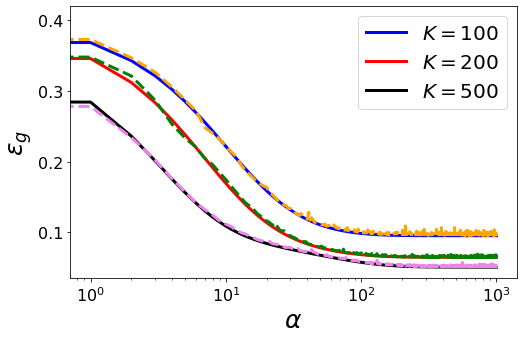

In [86]:
#compare simulation and ODE solution

i=0
plt.figure(figsize=(8,5))
plt.xlabel(r"$\alpha$",size=25)
plt.ylabel(r"$\epsilon_g$",size=25)
#plt.semilogx(multi_err33[0][0][:],linewidth=3,color="black") 
#plt.semilogx(err_ode3[:],linewidth=3,linestyle="--",color="violet",label='_nolegend_') 
a=0
b=1000
#plt.yscale("log")


plt.plot(ti2[slice(a,b)],(error100[i][1][slice(a,b)]),linewidth=3,color="blue")
plt.plot(error100[0][0][slice(a,b)],multi_errK100[0][0][slice(a,b)],linewidth=3,color="orange",linestyle="--",label='_nolegend_',alpha=1.)


plt.plot(ti2[slice(a,b)],(error200[i][1][slice(a,b)]),linewidth=3,color="red")
plt.plot(error200[0][0][slice(a,b)],multi_errK200[0][0][slice(a,b)],linewidth=3,color="green",label='_nolegend_',linestyle="--",alpha=1.)



plt.plot(ti2[slice(a,b)],df_ode[1][slice(a,b)],linewidth=3,color="black")
plt.plot(ti2[slice(a,b)],df_sim[1][slice(a,b)],linewidth=3,color="violet",linestyle="--",label='_nolegend_',alpha=1)

plt.xscale("log")



plt.ylim(0.035,0.42)
plt.xticks(fontsize=16)
plt.yticks([0.1,0.2,0.3,0.4],fontsize=16)

plt.legend([r"$K=100$",r"$K=200$",r"$K=500$"],fontsize=20)
#plt.savefig("odes_vs_simulation_N100_differentK_relu.pdf",bbox_inches="tight")
plt.show();
